[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD?labpath=feature_extraction.ipynb)

In [1]:
%matplotlib inline

import cv2
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import six

from collections import Counter, OrderedDict
from radiomics import featureextractor
from scipy import stats
from SimpleITK import GetImageFromArray
from skimage.filters import threshold_multiotsu
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from displaytools import *
from improcessing import *

extractor = featureextractor.RadiomicsFeatureExtractor()
# Enable everything but shape (3D) and glcm.SumAverage
extractor.disableAllFeatures()
extractor.enableFeaturesByName(firstorder=[],
                               shape2D=[],
                               glcm=['Autocorrelation', 'JointAverage', 'ClusterProminence',
                                     'ClusterShade', 'ClusterTendency', 'Contrast',
                                     'Correlation', 'DifferenceAverage', 'DifferenceEntropy',
                                     'DifferenceVariance', 'JointEnergy', 'JointEntropy',
                                     'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn',
                                     'InverseVariance', 'MaximumProbability', 'SumEntropy',
                                     'SumSquares'],
                               glszm=[],
                               glrlm=[],
                               ngtdm=[],
                               gldm=[])

scaler = StandardScaler()
pca = PCA(n_components='mle')
tsne = TSNE(learning_rate='auto', init='pca', random_state=0)

# Display Tools

In [2]:
# Crops image to a region of interest
def crop_image(image):
    x, y, w, h = cv2.boundingRect(image)
    return image[y:y+h, x:x+w]

def display_classifications(image, centroids, labels):
    plt.figure(dpi=240)
    plt.axis('off')
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.scatter(*zip(*centroids), s=20, c=labels, marker='+', cmap=colormap, linewidths=0.75)
    plt.show()

def display_contours(image, masks, labels):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    for i in range(len(masks)):
        mask = masks[i]
        color = np.array(matplotlib.colors.to_rgb(colormap.colors[labels[i]]))*255
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        image = cv2.drawContours(image, contours, contourIdx=-1, color=color, thickness=1)
    display_image(image)
    
def display_rois(image, masks, labels):
    for c in range(labels.min(), labels.max()+1):
        indices = np.where(labels==c)[0]
        print("Class %i, with %i ROIs:" % (c, len(indices)))
        masked = image*masks[indices]
        cropped = list(map(crop_image, masked))
        display_image_array(cropped, columns=10, dpi=150)

def display_tsne(df):
    transformed = tsne.fit_transform(df)
    plt.scatter(transformed[:,0], transformed[:,1], s=5, c=labels)
    plt.show()

def print_classification_counts(labels):
    c = Counter(labels)
    for k in sorted(c):
        print("Class %s (%s): %i (%.2f%%)" %
              (k, colormap.colors[k], c[k], c[k]*100/sum(c.values())))

# Iteration Logic

In [3]:
def extract_features(image, mask_image, size_thresh=75):
    num_components, labelled, stats, centroids = \
            cv2.connectedComponentsWithStats(mask_image, connectivity=8)

    features = OrderedDict()
    masks = []

    for i in range(1, len(stats)):  # index 0 is the background component
        size = stats[i, -1]
        if size < size_thresh:
            continue
        mask = np.uint8(labelled == i)
        masks += [mask,]
        result = extractor.execute(GetImageFromArray(image),
                                   GetImageFromArray(mask))
        if len(features) == 0:
            features['x'] = [int(centroids[i][0])]
            features['y'] = [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] = [val]
        else:
            features['x'] += [int(centroids[i][0])]
            features['y'] += [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] += [val]

    return pd.DataFrame.from_dict(features).set_index(['x', 'y']), np.array(masks)

def get_mask_image(image, params, mode="thresh_adaptive", verbose=False):
    if verbose:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        hist1 = cv2.calcHist([image], [0], None, [256], [0,256])
        ax1.plot(hist1)
        ax1.set_title("Raw Image")
        ax1.set_xlim([0,256])
        ax1.set_ylim([0,hist1.max()])

    if params['denoise_pre']:
        image = apply_denoise(image, params['denoise_pre'])

    if params['contrast']:
        peak = cv2.calcHist([image], [0], None, [256], [0,256]).argmax()
        image = np.uint8(np.clip((params['contrast']*(np.float64(image)-peak)) + peak,
                                 0, 255))
    
    if params['clipLimit']:
        image = cv2.createCLAHE(params['clipLimit'], tileGridSize=(8,8)) \
                   .apply(image)
    
    if params['denoise_post']:
        image = apply_denoise(image, params['denoise_post'])
        
    if mode == "background_filter":
        peak = cv2.calcHist([image], [0], None, [256], [0,256]).argmax()
        binarized = np.uint8((image < peak - params['lower_width']) | \
                             (image > peak + params['upper_width']))
    elif mode == "edge_canny":
        image = apply_sharpen(image)
        binarized = apply_canny(image, params['threshold1'], params['threshold2'])
    elif mode == "edge_sobel":
        image = apply_sharpen(image)
        sobel = apply_sobel(image, params['sobel_ks'])
        _, binarized = cv2.threshold(sobel, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    elif mode == "kmeans":
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, labels, _ = cv2.kmeans(np.float32(raw_image.flatten()), 2, None, criteria,
                       params['attempts'], cv2.KMEANS_PP_CENTERS)
        binarized = np.uint8(labels.reshape(image.shape))
        if stats.mode(labels.flatten()).mode[0]:
            binarized = cv2.bitwise_not(binarized)
    elif mode == "thresh_adaptive":
        binarized = cv2.adaptiveThreshold(image, 255,
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV,
                                          params['thresh_ks'], params['C'])
    elif mode == "thresh_otsu":
        _, binarized = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    else:
        print("Invalid mask mode, aborting.")
        return None
    
    filled = apply_imfill(apply_closure(binarized, kernel_size=params['closure_ks']))
    
    if verbose:
        ax2.plot(cv2.calcHist([image], [0], None, [256], [0,256]))
        ax2.set_title("Preprocessed")
        ax2.set_xlim([0,256])
        ax2.set_ylim([0,hist1.max()])

        display_image_array([image, binarized, filled],
                            ["Preprocessed", "Binarized", "Filled"], columns=3, dpi=450)

    return filled

def process_features(df):
    return pd.DataFrame(pca.transform(scaler.transform(df.values)),
                        index=df.index)

# Image preprocessing parameters

In [4]:
mode = "thresh_adaptive"

params = {
    ##################################################
    ###### PREPROCESSING #############################
    ### set to 0 to disable ##########################

    'denoise_pre': 0,
    
    # background separation
    'contrast': 1.5,  # contrast boosting factor

    # histogram equalization
    'clipLimit': 0,  # contrast limit for clipping
    
    'denoise_post': 3,

    ##################################################

    ##################################################
    ###### BINARIZATION MODE #########################
    ### set `mode` to one of the following ###########
    ### other params will be ignored #################

    # "background_filter"
    'lower_width': 10,  # distances from peak
    'upper_width': 10,
    
    # "edge_canny"
    'threshold1': 30,  # lower values are ignored
    'threshold2': 210, # middle values considered if
                       # connected to upper values
    
    # "edge_sobel"
    'sobel_ks': 5,
    
    # "kmeans"
    'attempts': 10,  # number of times to repeat
    
    # "thresh_adaptive"
    'thresh_ks': 151,
    'C': 8,
    
    # "thresh_otsu"
    # No params needed

    ##################################################
    
    # image closure kernel size
    'closure_ks': 3,
}

# Fit and classify on control image

## Create mask image and extract raw features

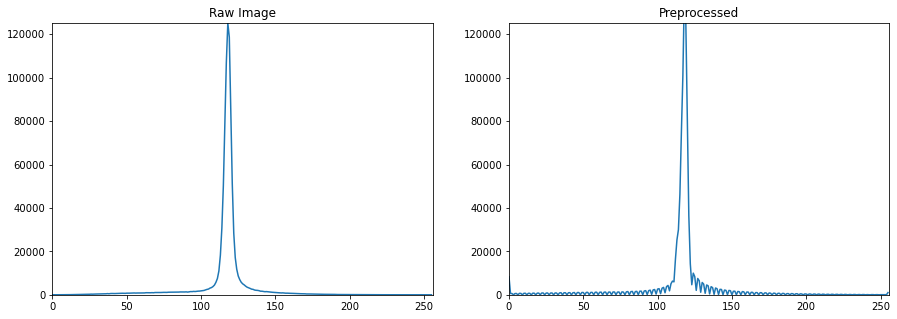

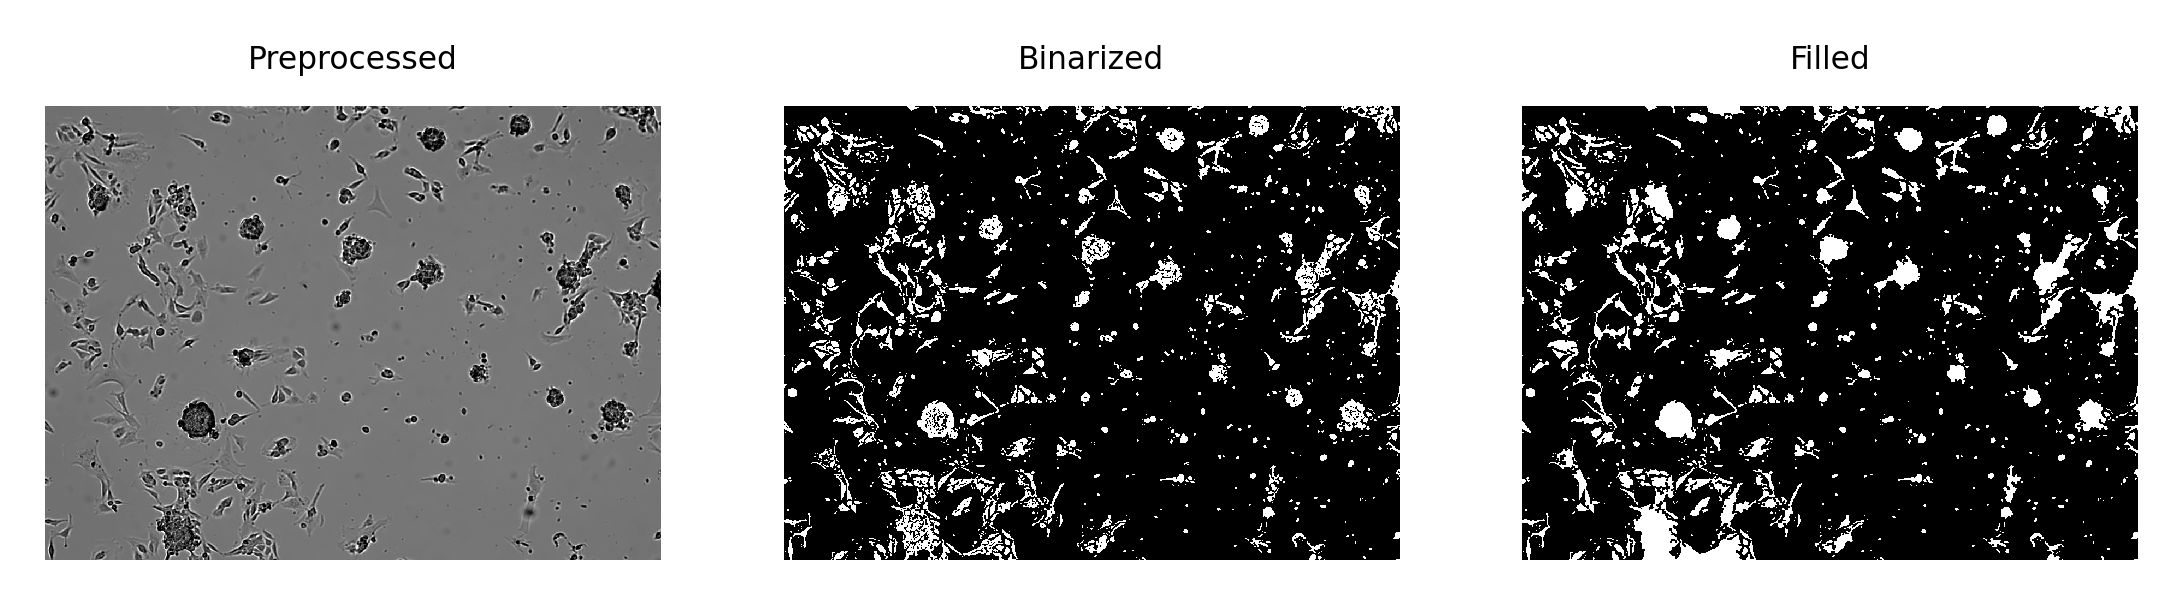

original_shape2D_Elongation  original_shape2D_MajorAxisLength  \
x   y                                                                    
235 2                       0.424264                         20.450275   
371 7                       0.307904                         68.448547   
476 3                       0.640030                         15.430833   
541 14                      0.514036                         31.675234   
575 3                       0.403519                         25.020983   
...                              ...                               ...   
972 816                     0.738282                         41.133156   
177 811                     0.433917                         24.316580   
407 815                     0.581474                         15.038612   
100 823                     0.458883                         31.811492   
169 824                     0.598243                         18.540161   

        original_shape2D_MaximumDiameter original_shape2D_MeshSurface  \
x   y                                                                   
235 2                 21.213203435596427                        119.5   
371 7                  70.21395872616783                        932.5   
476 3                               17.0                        105.5   
541 14                30.528675044947494                        335.5   
575 3                 25.495097567963924                        183.5   
...                                  ...                          ...   
972 816                42.20189569201838                        419.0   
177 811               26.076809620810597                        188.5   
407 815               15.033296378372908                         99.5   
100 823                35.77708763999664                        261.0   
169 824                             20.0                        146.5   

         original_shape2D_MinorAxisLength original_shape2D_Perimeter  \
x   y                                                                  
235 2                            8.676317          54.97056274847711   
371 7                           21.075565         212.22539674441668   
476 3                            9.876189          45.79898987322329   
541 14                          16.282211          89.59797974644671   
575 3                           10.096442           67.2132034355964   
...                                   ...                        ...   
972 816                         30.367883         194.85281374238605   
177 811                         10.551375          69.35533905932733   
407 815                          8.744561           41.2132034355964   
100 823                         14.597745         122.66904755831224   
169 824                         11.091530          53.55634918610403   

        original_shape2D_PerimeterSurfaceRatio  original_shape2D_PixelSurface  \
x   y                                                                           
235 2                      0.46000470919227704                          120.0   
371 7                      0.22758755683047366                          933.0   
476 3                       0.4341136480874246                          106.0   
541 14                     0.26705806183739705                          336.0   
575 3                       0.3662844873874463                          184.0   
...                                        ...                            ...   
972 816                    0.46504251489829607                          420.0   
177 811                     0.3679328332059806                          189.0   
407 815                     0.4142030496039839                          100.0   
100 823                     0.4699963507981312                          262.0   
169 824                    0.36557234939320155                          147.0   

         original_shape2D_Sphericity original_firstorder_10Percentile  ...  \
x   y                      

In [5]:
raw_image = cv2.imreadmulti('source_images/Control.tif')[1][0]
mask_image = get_mask_image(raw_image, params, mode=mode, verbose=True)
df, masks = extract_features(raw_image, mask_image)
display(df)

## Scale features and reduce dimensions

In [6]:
scaler.fit(df.values)
pca.fit(df.values)

df = process_features(df)
display(df)

0             1             2           3           4   \
x   y                                                                       
235 2   -5.472197e+06 -50172.274390 -12815.501101 -601.809694 -169.694805   
371 7   -5.472195e+06 -50177.228252 -12810.706884 -605.714179 -164.848326   
476 3   -5.472197e+06 -50177.275021 -12816.284111 -599.772195 -168.119745   
541 14  -5.472197e+06 -50177.275811 -12816.258933 -599.716721 -168.135737   
575 3   -5.472197e+06 -50177.274952 -12816.286468 -599.767753 -168.096220   
...               ...           ...           ...         ...         ...   
972 816 -5.472197e+06 -50177.276598 -12816.337227 -599.700263 -168.247918   
177 811 -5.472197e+06 -50177.275256 -12816.300066 -599.742742 -168.118183   
407 815 -5.472197e+06 -50177.274253 -12816.279961 -599.790441 -168.045382   
100 823 -5.472197e+06 -50177.275451 -12816.201436 -599.720351 -168.093712   
169 824 -5.472197e+06 -50177.273878 -12816.239420 -599.847694 -168.047049   

                5           6          7           8          9   ...  \
x   y                                                             ...   
235 2   -39.051603 -486.990691  98.098114  219.479999  30.671261  ...   
371 7   -37.875617 -485.414019  99.670256  215.533551  30.614943  ...   
476 3   -35.464496 -486.117463  97.312720  219.441214  30.831241  ...   
541 14  -35.258046 -484.982285  97.363211  218.100914  30.696559  ...   
575 3   -35.493716 -486.189766  97.540650  218.961840  30.861987  ...   
...            ...         ...        ...         ...        ...  ...   
972 816 -34.758010 -483.029535  96.930983  218.628427  32.082774  ...   
177 811 -35.428111 -485.947753  97.434238  218.917082  30.884426  ...   
407 815 -35.720304 -487.086558  97.630862  218.997377  30.415009  ...   
100 823 -35.391623 -485.372656  97.330043  217.523188  30.637271  ...   
169 824 -35.648224 -486.835098  97.715296  219.335622  30.859775  ...   

               87        88        89        90        91        92        93  \
x   y                                                                           
235 2    0.479011  1.207188  0.121676  0.475351  1.076207  1.565577 -1.614471   
371 7   -0.143181 -0.114294  0.482827  0.997612  0.781545  0.065260 -2.298328   
476 3   -0.502991  0.523321  0.378111 -0.277114 -1.000687  1.070730 -0.189284   
541 14   0.267708 -0.335710  0.675475 -0.588183 -1.133674 -0.349924 -0.541515   
575 3   -0.109407  0.410332  0.511118 -0.229760 -1.241755  0.562286 -0.568086   
...           ...       ...       ...       ...       ...       ...       ...   
972 816  0.280854 -0.253917 -0.331900 -1.711200 -1.283757  0.734752  0.523108   
177 811 -0.039719  0.703941  0.153915 -0.499333 -1.468979  1.102620  0.023701   
407 815 -0.705682  1.100625  0.137167  0.009042 -1.003542  1.666947 -0.773996   
100 823 -0.159294 -0.410959  0.716674 -0.394193 -0.796605  0.067901 -0.490016   
169 824 -0.691923  1.275639  0.099887 -0.035155 -1.418913  2.433148  0.154852   

               94        95        96  
x   y                                  
235 2   -0.319790 -0.198081  0.045620  
371 7   -0.406095  0.164630 -0.020858  
476 3   -0.061426  1.123296 -0.222623  
541 14   0.174882  1.463180 -0.275128  
575 3   -0.098236  1.101646 -0.215907  
...           ...       ...       ...  
972 816  0.449713  1.996341 -0.373436  
177 811 -0.062346  1.397229 -0.274717  
407 815 -0.391355  0.650076 -0.132129  
100 823  0.110281  1.178571 -0.219398  
169 824 -0.293656  1.000214 -0.210267  

[211 rows x 97 columns]

## Determine number of clusters

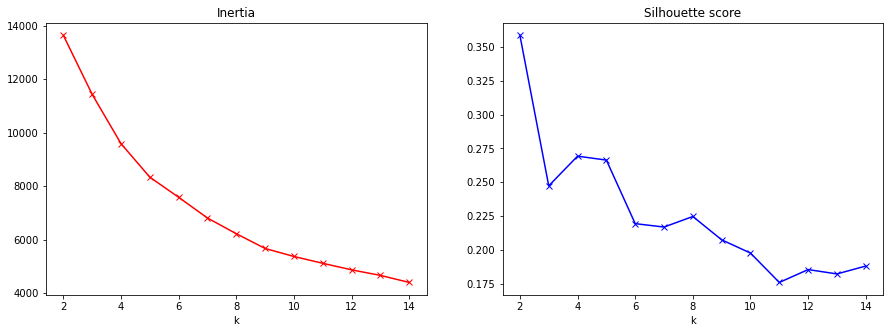

In [7]:
inertias = []
silhouette_scores = []
K = range(2, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(df)
    inertias += [kmeans.inertia_,]
    silhouette_scores += [silhouette_score(df, labels),]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(K, inertias, 'rx-')
ax1.set(xlabel='k', title="Inertia")
ax2.plot(K, silhouette_scores,'bx-')
ax2.set(xlabel='k', title="Silhouette score")
plt.show()

### User-defined values

In [8]:
# Manually select k based on visual inspection above
k = 4

# Classification colors (include k colors, or use colormap string)
colormap = matplotlib.colors.ListedColormap(['yellow', 'red', 'cyan', 'orange'])

## Fit and classify using silhouette score

In [9]:
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(df)
labels = kmeans.predict(df)
print_classification_counts(labels)

Class 0 (yellow): 97 (45.97%)
Class 1 (red): 60 (28.44%)
Class 2 (cyan): 44 (20.85%)
Class 3 (orange): 10 (4.74%)


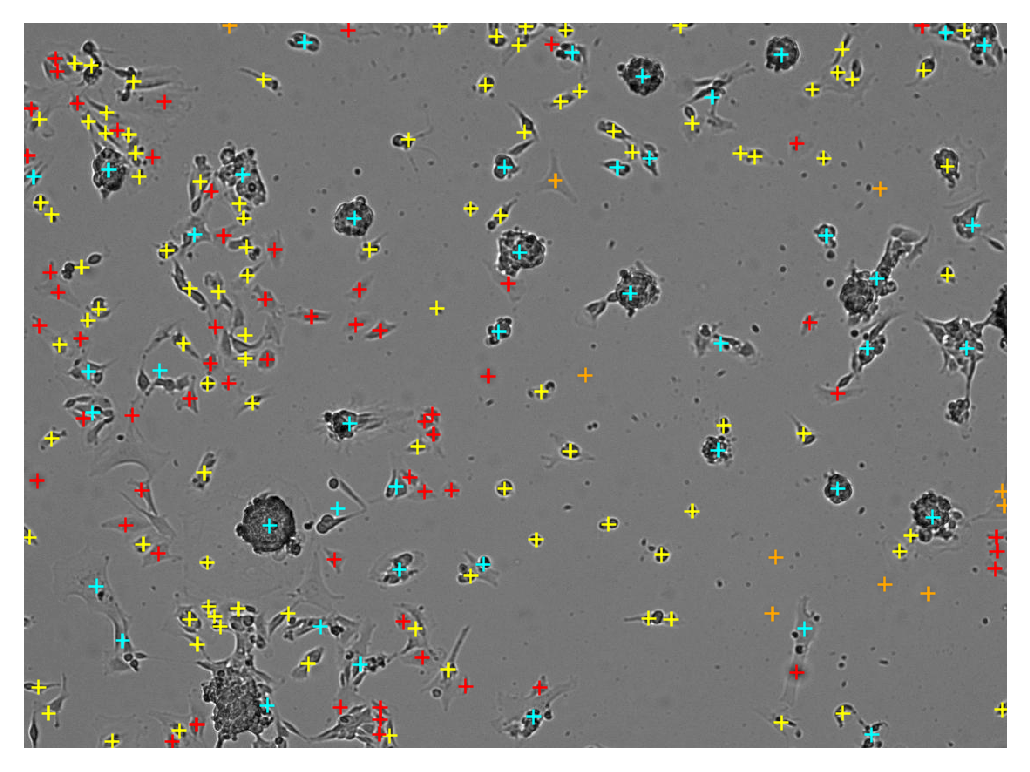

In [10]:
display_classifications(raw_image, df.index, labels)

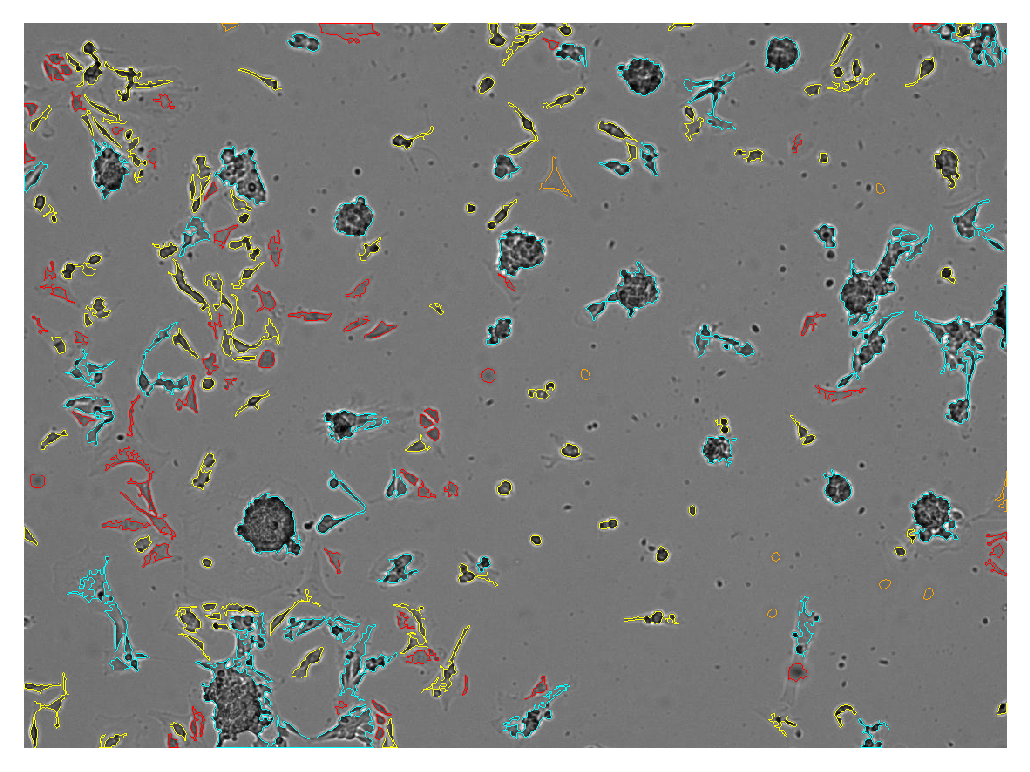

In [11]:
display_contours(raw_image, masks, labels)

Class 0, with 97 ROIs:


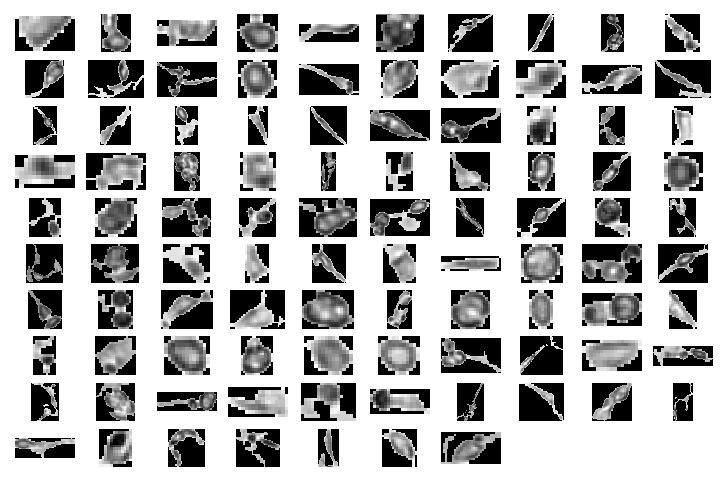

Class 1, with 60 ROIs:


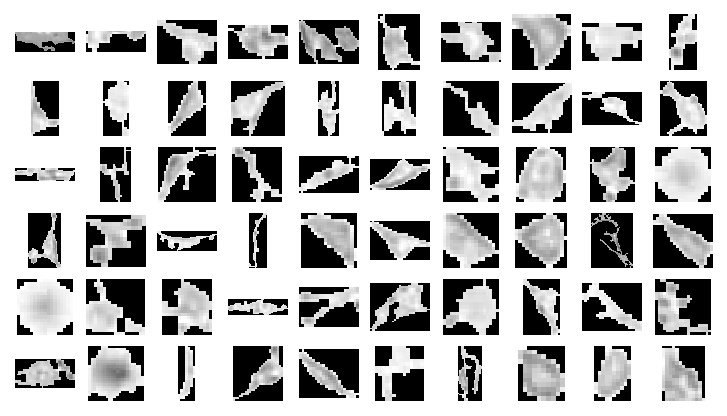

Class 2, with 44 ROIs:


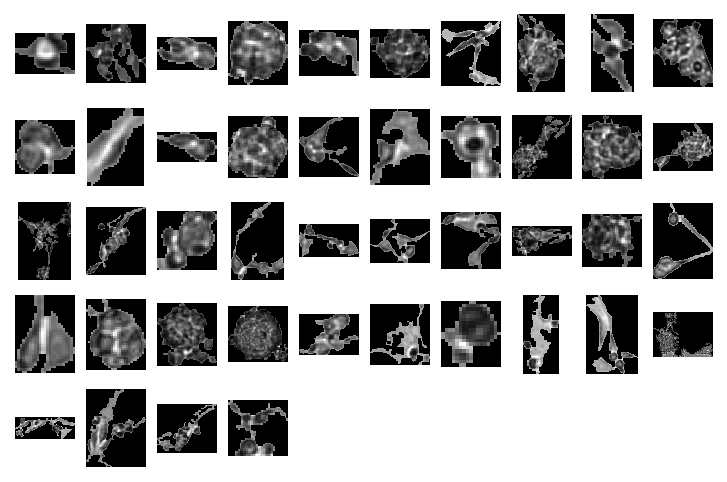

Class 3, with 10 ROIs:


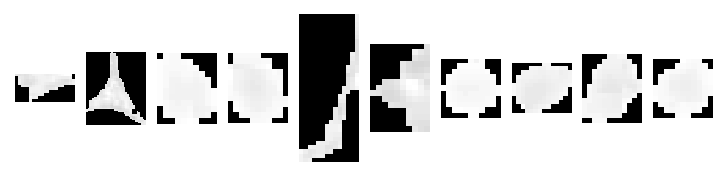

In [12]:
display_rois(raw_image, masks, labels)

## Cluster visualization

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


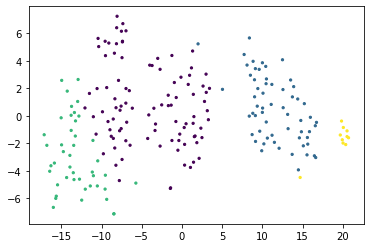

In [13]:
display_tsne(df)

# Experiment w/ multi-Otsu

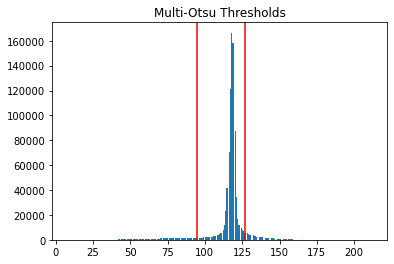

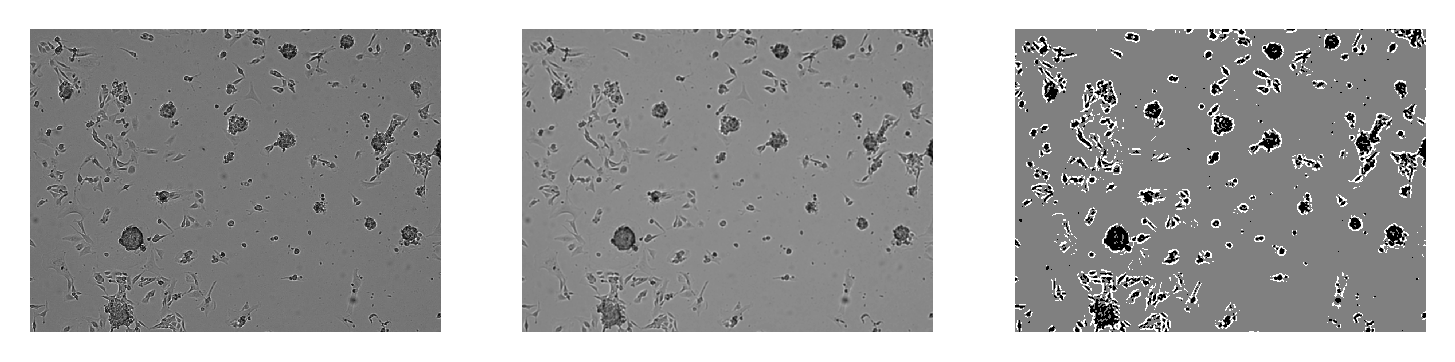

In [14]:
blurred = apply_blur(raw_image, 5)
thresholds = threshold_multiotsu(blurred)
multi_otsu_regions = np.digitize(blurred, bins=thresholds)

plt.hist(blurred.ravel(), bins=255)
plt.title('Multi-Otsu Thresholds')
for thresh in thresholds:
    plt.axvline(thresh, color='r')

display_image_array([raw_image, blurred, multi_otsu_regions],
                    columns=3, dpi=300)

# Classify cells on adherent image

In [15]:
raw_image = cv2.imreadmulti('source_images/Adherent.tif')[1][0]
mask_image = get_mask_image(raw_image, params, mode=mode)
df, masks = extract_features(raw_image, mask_image)
df = process_features(df)
labels = kmeans.predict(df)
print_classification_counts(labels)

Class 0 (yellow): 56 (33.53%)
Class 1 (red): 70 (41.92%)
Class 2 (cyan): 40 (23.95%)
Class 3 (orange): 1 (0.60%)


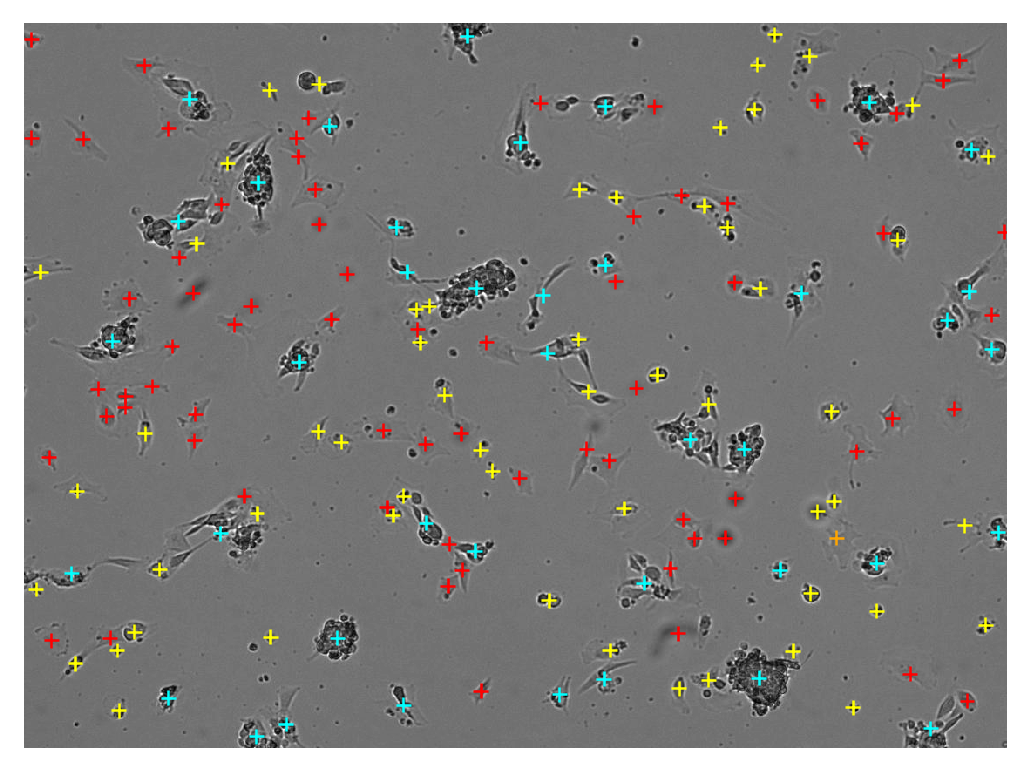

In [16]:
display_classifications(raw_image, df.index, labels)

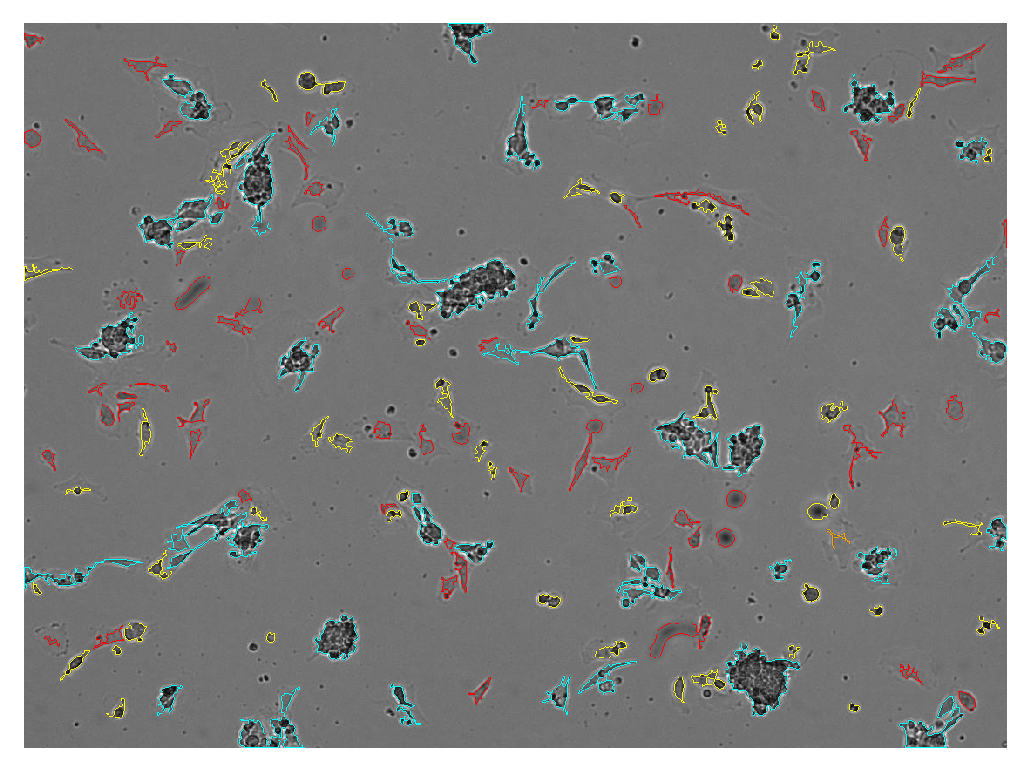

In [17]:
display_contours(raw_image, masks, labels)

Class 0, with 56 ROIs:


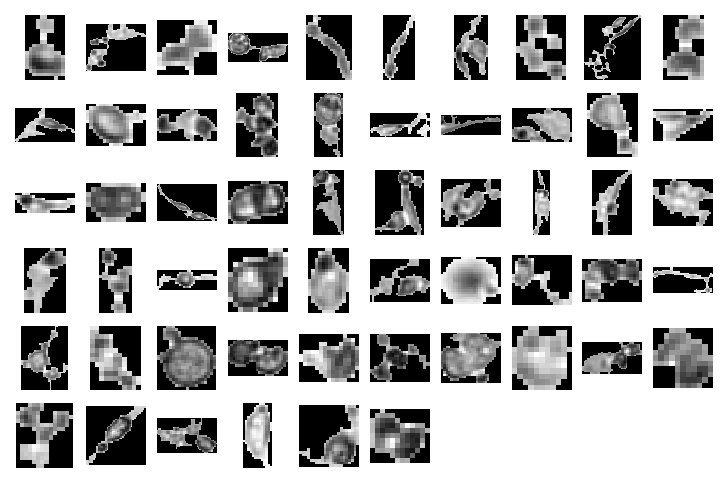

Class 1, with 70 ROIs:


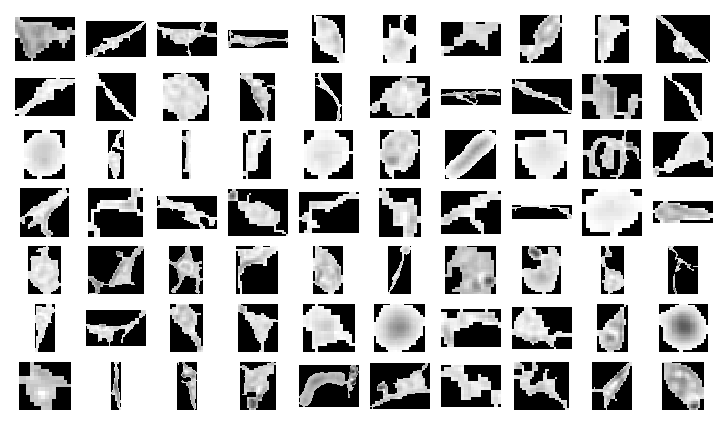

Class 2, with 40 ROIs:


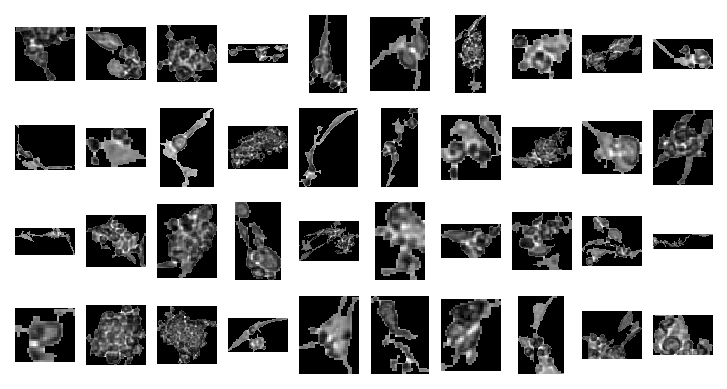

Class 3, with 1 ROIs:


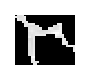

In [18]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


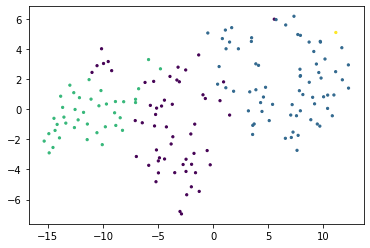

In [19]:
display_tsne(df)

# Classify cells on suspension image

In [20]:
raw_image = cv2.imreadmulti('source_images/Suspension.tif')[1][0]
mask_image = get_mask_image(raw_image, params, mode=mode)
df, masks = extract_features(raw_image, mask_image)
df = process_features(df)
labels = kmeans.predict(df)
print_classification_counts(labels)

Class 0 (yellow): 79 (45.66%)
Class 1 (red): 70 (40.46%)
Class 2 (cyan): 22 (12.72%)
Class 3 (orange): 2 (1.16%)


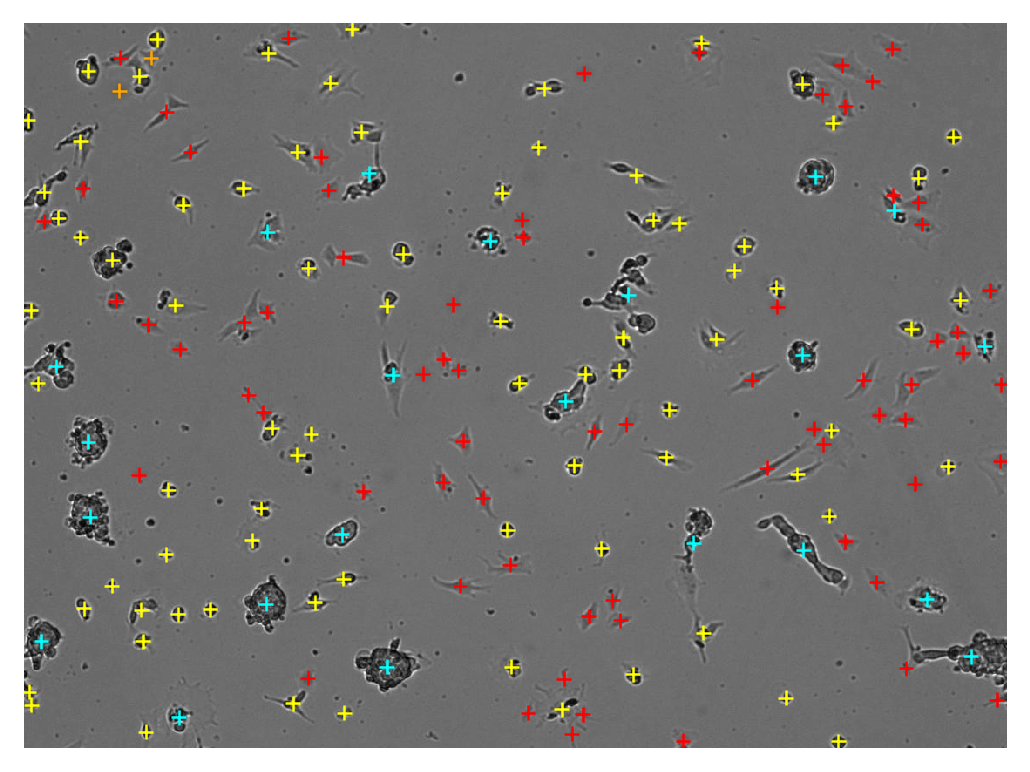

In [21]:
display_classifications(raw_image, df.index, labels)

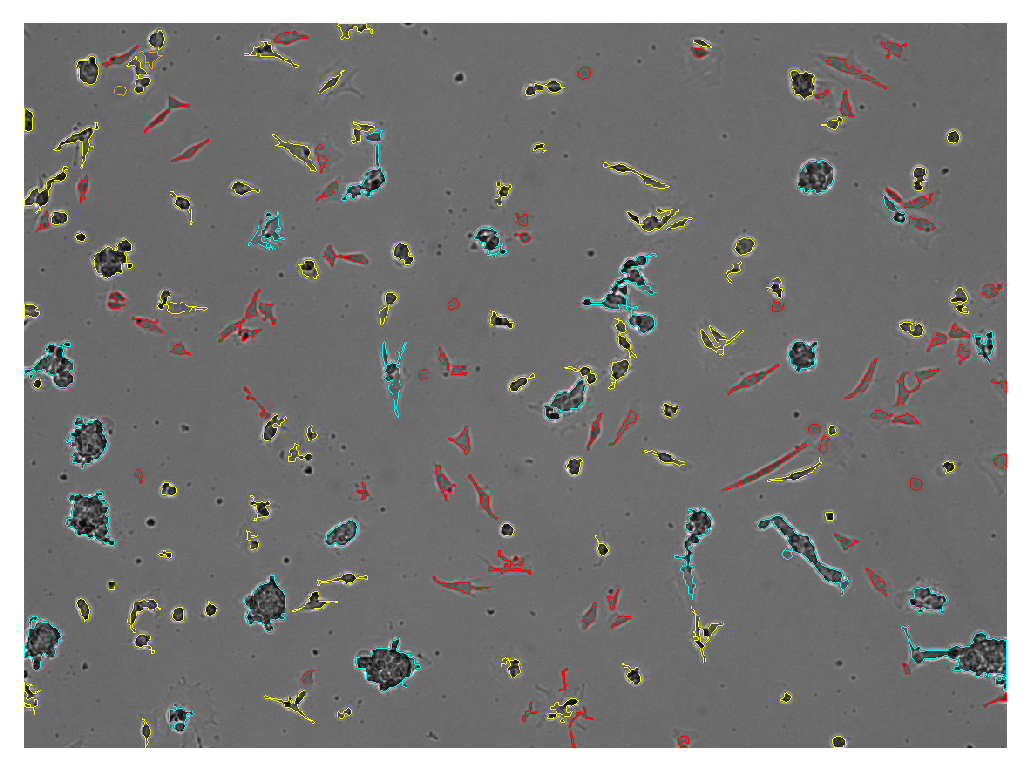

In [22]:
display_contours(raw_image, masks, labels)

Class 0, with 79 ROIs:


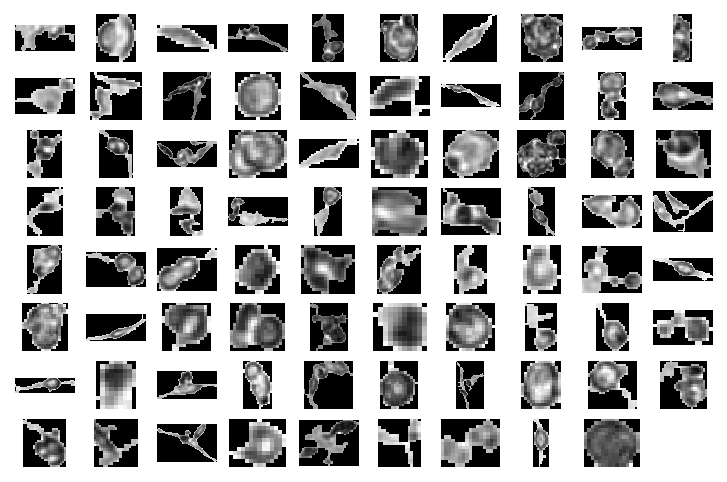

Class 1, with 70 ROIs:


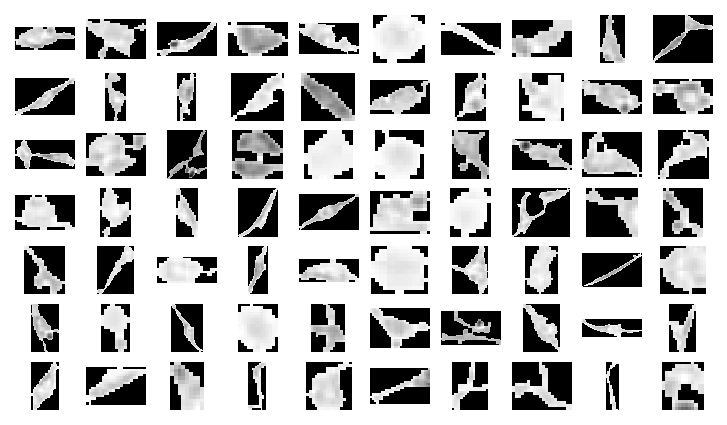

Class 2, with 22 ROIs:


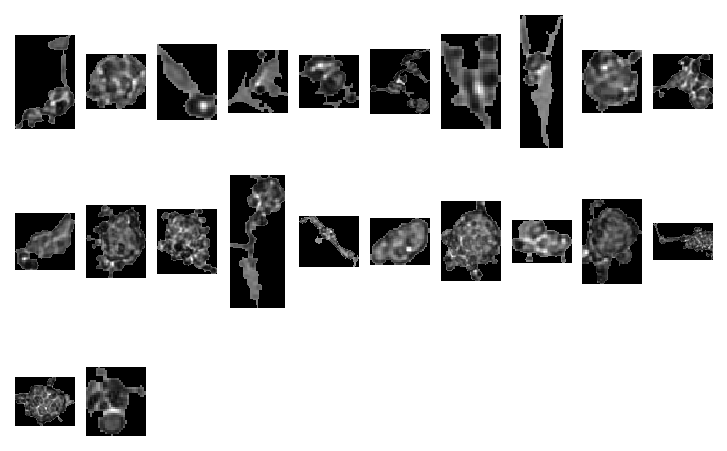

Class 3, with 2 ROIs:


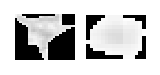

In [23]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


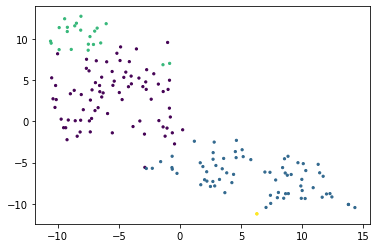

In [24]:
display_tsne(df)